# Dataloading

In [7]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random
import numpy as np

TRAIN_DIR = "/home/undergrad/2026/wcarvalh/Documents/spring-2025/chm/hw4/data/TRAIN_NEW"
# Load the connectome CSV file without the first column (which contains patient IDs)
connectome_df_no_labels = pd.read_csv(TRAIN_DIR + '/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv', index_col=0)

categorical_df = pd.read_excel("./data/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
solutions_df = pd.read_excel("./data/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")

# load categorical labels
with open("categorical_labels.json", "r") as file:
    categorical_labels = json.load(file)

# json cant store keys of type int, cast int keys back to int
categorical_labels = {category: {int(key): label for key, label in mapping.items()} for category, mapping in categorical_labels.items()}

# Preprocessing
## GNN Baseline

In [10]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GCNConv, EdgeConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [12]:
# get the number of patients and the length of the vector for each patient
num_patients = connectome_df_no_labels.shape[0]
vector_length = connectome_df_no_labels.shape[1]

# reconstruct the matrix size from the vector length
n = int((1 + math.sqrt(1 + 8 * vector_length)) / 2)  # should be 200

# initialize a 3d numpy array to store all matrices
connectome_array = np.zeros((num_patients, n, n))

# fill the array with each patient's full matrix
for patient_index in range(num_patients):
    patient_vector = connectome_df_no_labels.iloc[patient_index].values

    matrix = np.zeros((n, n))
    lower_indices = np.tril_indices(n, k=-1)
    matrix[lower_indices] = patient_vector
    matrix = matrix + matrix.T  # make it symmetric
    np.fill_diagonal(matrix, 1)  # set diagonal to 1

    connectome_array[patient_index] = matrix

# convert our data to torch tensors
connectivity_matrices = torch.tensor(connectome_array).float()
labels_sex = torch.tensor(solutions_df['Sex_F']).float()
labels_diagnosis = torch.tensor(solutions_df['ADHD_Outcome']).float()

# stack the target variable labels
labels = torch.stack([labels_diagnosis, labels_sex],dim=1)

# create graph data objects for each matrix
data_list = []
for i in range(len(connectivity_matrices)):
    matrix = connectivity_matrices[i]
    #edge_index = (matrix > 0).nonzero(as_tuple=False).t() # create edges based on non-zero entries
    #edge_attr = matrix[edge_index[0], edge_index[1]] # edge weights are the matrix values
    k = 10  # or 15, depending on how sparse you want the graph

    # list to collect top-k edges
    edges = []
    weights = []

    for node in range(n):
        # get connection strengths to all other nodes
        connections = matrix[node]

        # exclude self-connections
        connections[node] = -float("inf")

        # get top-k indices
        topk_indices = torch.topk(connections, k=k).indices

        for target in topk_indices:
            edges.append([node, target.item()])
            weights.append(matrix[node, target].item())

    # convert to edge_index and edge_attr
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()  # shape [2, num_edges]
    edge_attr = torch.tensor(weights, dtype=torch.float)  # shape [num_edges]

    x = torch.eye(200) # node features (identity matrix as features)
 
    # create graph data object
    graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=labels_diagnosis[i].unsqueeze(0))
    data_list.append(graph_data)
    #print(graph_data)
torch.manual_seed(192024)


## Model Development

In [13]:
# defining the model
class GCN(torch.nn.Module):
    def __init__(self, in_channels=200, hidden_channels=64, num_classes=1):
        super(GCN, self).__init__()
        # shared mlp used in all EdgeConv layers
        self.edge_mlp1 = Sequential(Linear(2 * in_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.edge_mlp2 = Sequential(Linear(2 * hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.edge_mlp3 = Sequential(Linear(2 * hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.edge_mlp4 = Sequential(Linear(2 * hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.edge_mlp5 = Sequential(Linear(2 * hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))

        self.conv1 = EdgeConv(nn=self.edge_mlp1)
        self.conv2 = EdgeConv(nn=self.edge_mlp2)
        self.conv3 = EdgeConv(nn=self.edge_mlp3)
        self.conv4 = EdgeConv(nn=self.edge_mlp4)
        self.conv5 = EdgeConv(nn=self.edge_mlp5)

        self.lin = Linear(hidden_channels, num_classes)
        
    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x1 = self.conv1(x, edge_index)
        x2 = self.conv2(x1, edge_index) + x1  # skip connection
        x3 = self.conv3(x2, edge_index) + x2
        x4 = self.conv4(x3, edge_index) + x3
        x5 = self.conv5(x4, edge_index) + x4
        
        x_pool = global_mean_pool(x5, batch)

        out = self.lin(x_pool).squeeze(1)
        #print("out", out)
        #print(x_pool.view(-1))
        #return x_pool.view(-1) # ensuring output has the correct shape (batch_size,)
        return out

## Data Splitting and Model Training
### First on ADHD Diagnosis

In [31]:
def train(train_loader):
    model.train()
    total_loss = 0
    for data in train_loader: # load batches from data loader
        optimizer.zero_grad() # reset gradients
        out = model(data) # pass batch thru model to obtain predictions (forward pass)
        loss = criterion(out, data.y) # calculate loss between predictions and true labels
        loss.backward() # backpropagate the loss to compute gradients
        optimizer.step() # update the model's parameters using the gradients
        total_loss += loss.item() # accumulate batch loss into total loss
    return total_loss / len(train_loader)

def evaluate_model(model, data_loader):
    model.eval()
    actual_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for data in data_loader:
            out = model(data)                # shape: [batch_size,]
            preds = torch.sigmoid(out)       # get probabilities
            predicted_labels.append(preds.cpu())
            actual_labels.append(data.y.cpu()) # true labels

    # concat into full tensors
    actual_labels = torch.cat(actual_labels, dim=0)
    predicted_labels = torch.cat(predicted_labels, dim=0)
    #print(predicted_labels)
    # binarize predictions using threshold 0.5
    bin_preds = (predicted_labels >= 0.5).int()

    return actual_labels.numpy(), bin_preds.numpy(), predicted_labels.numpy()

In [20]:
# apply a data split here: training --> training/validation, test
labels_arr = labels_diagnosis.numpy() 
X_trainval, X_test, y_trainval, y_test = train_test_split(data_list, labels_arr, test_size=0.2, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gnn_scores = []
y_preds = []
y_vals = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    # split data
    train_data = [X_trainval[i] for i in train_idx]
    val_data = [X_trainval[i] for i in val_idx]
    y_val = y_trainval[val_idx]

    # data loaders
    train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

    # training the model
    model = GCN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # set up optimizer
    criterion = torch.nn.BCEWithLogitsLoss() # define criterion

    # train the model for a number of epochs
    losses = []
    for epoch in range(100):
        loss = train(train_loader)
        losses.append(loss)
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}')
            
    epochs =list(range(1, len(losses) + 1))

    # evaluate on validation set
    y_true, y_pred, y_probs = evaluate_model(model, val_loader)
    f1 = f1_score(y_true, y_pred, average="macro")
    gnn_scores.append(f1)
    y_preds.extend(y_pred)
    y_vals.extend(y_val)

Epoch 0, Loss: 0.6536
Epoch 10, Loss: 0.6399
Epoch 20, Loss: 0.6303
Epoch 30, Loss: 0.5930
Epoch 40, Loss: 0.2182
Epoch 50, Loss: 0.3177
Epoch 60, Loss: 0.0004
Epoch 70, Loss: 0.0000
Epoch 80, Loss: 0.0000
Epoch 90, Loss: 0.0000
tensor([1.0000e+00, 9.9998e-01, 9.9997e-01, 2.9456e-03, 1.0000e+00, 5.7615e-01,
        1.0000e+00, 2.1586e-03, 8.9563e-01, 9.9941e-01, 1.0000e+00, 9.8952e-01,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        9.5734e-01, 9.9999e-01, 1.0000e+00, 1.0000e+00, 5.4664e-03, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 9.9985e-01, 1.0000e+00, 9.9330e-01,
        1.8059e-05, 2.3882e-08, 1.1464e-04, 2.2458e-08, 9.5743e-03, 3.5934e-02,
        9.9993e-01, 1.0000e+00, 1.0000e+00, 2.8109e-07, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 6.0363e-08, 1.9079e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        9.1723e-01, 1.0000e+00, 2.9205e-04, 1.0000e+00, 5.3975e-05, 1.0000e+00,
        3.1759e-01, 1.0000e+00, 1.0596e-01, 1.0000e

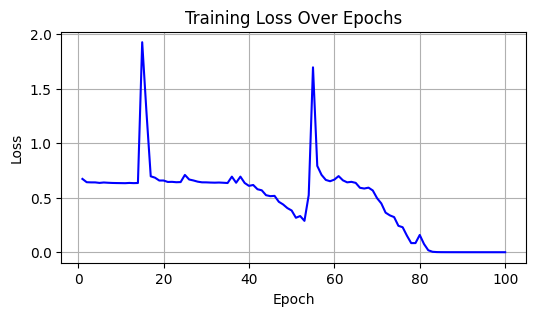

In [21]:
# visualize loss values
plt.figure(figsize=(6, 3))
plt.plot(epochs, losses, linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

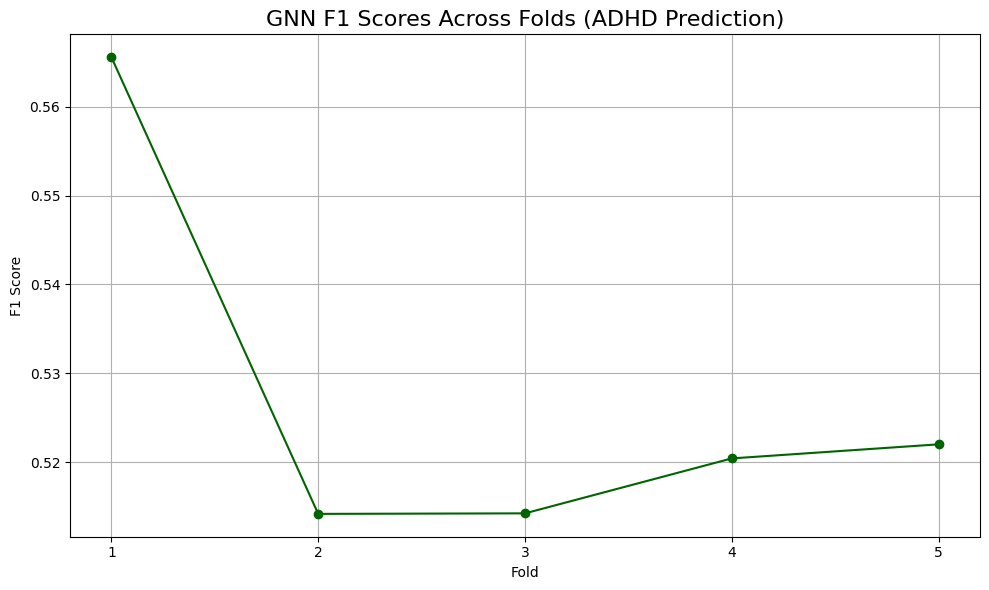

In [22]:
# F1 Scores
#print(gnn_scores)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), gnn_scores, marker='o', linestyle='-', color='darkgreen')
plt.title("GNN F1 Scores Across Folds (ADHD Prediction)", fontsize=16)
plt.xlabel("Fold")
plt.ylabel("F1 Score")
plt.xticks(range(1, 6))
plt.grid(True)
plt.tight_layout()
plt.show()

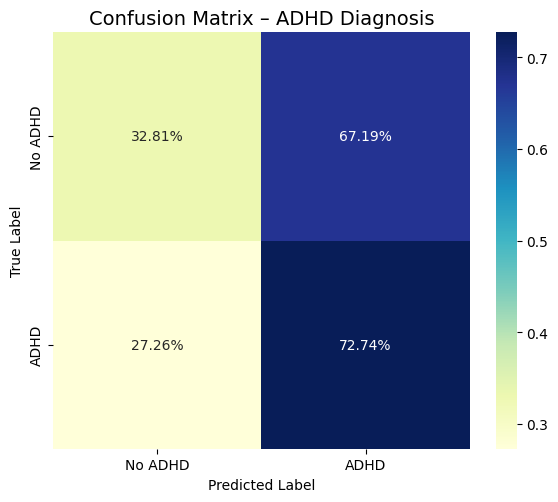

In [25]:
# Confusion Matrix
#print(y_preds)
#print(y_vals)
cm = confusion_matrix(y_vals, y_preds)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, cmap="YlGnBu", fmt=".2%", square=True, cbar=True)
plt.title(f"Confusion Matrix – ADHD Diagnosis", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.xticks([0.5, 1.5], ["No ADHD", "ADHD"]) 
plt.yticks([0.5, 1.5], ["No ADHD", "ADHD"]) 

plt.tight_layout()
plt.show()

In [ ]:
# Classification Report

print("\nClassification Report (Aggregated Predictions Across Folds):")
print(classification_report(y_vals, y_preds, digits=3))


Classification Report (Aggregated Predictions Across Folds):
              precision    recall  f1-score   support

         0.0      0.369     0.328     0.347       317
         1.0      0.690     0.727     0.708       653

    accuracy                          0.597       970
   macro avg      0.530     0.528     0.528       970
weighted avg      0.585     0.597     0.590       970




Classification Report #2:
              precision    recall  f1-score   support

         0.0      0.212     0.277     0.240        65
         1.0      0.703     0.624     0.661       178

    accuracy                          0.531       243
   macro avg      0.457     0.450     0.450       243
weighted avg      0.571     0.531     0.548       243



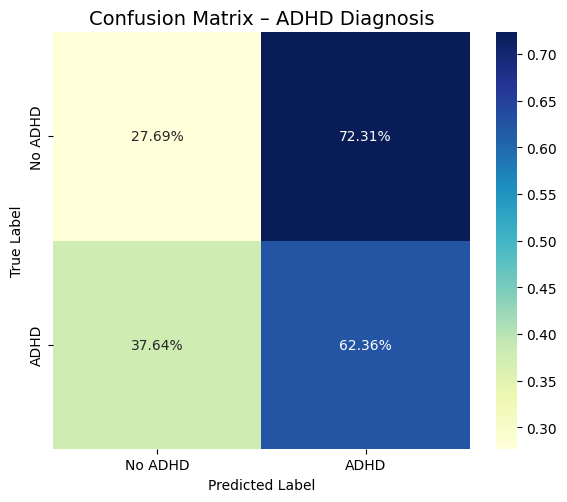

In [34]:
# TESTING!!! NEED TO FINISH
# define test_loader
test_loader = DataLoader(X_test, batch_size=8, shuffle=False)

y_true, y_pred, y_probs = evaluate_model(model, test_loader)

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print("\nClassification Report #2:")
print(classification_report(y_true, y_pred, digits=3))

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, cmap="YlGnBu", fmt=".2%", square=True, cbar=True)
plt.title(f"Confusion Matrix – ADHD Diagnosis", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.xticks([0.5, 1.5], ["No ADHD", "ADHD"]) 
plt.yticks([0.5, 1.5], ["No ADHD", "ADHD"]) 

plt.tight_layout()
plt.show()